## Linh Nguyen - ID 170037344

# SMM750 - Final coursework

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay, accuracy_score, confusion_matrix, roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2]:
# Load data
data_raw = pd.read_csv('./data/employee_attrition_previous_closure.csv')

In [3]:
# Create definitions
def encode(X, encoder):
    X = pd.concat(
        [
            X.drop(encoder.feature_names_in_, axis=1),
            pd.DataFrame(
                encoder.transform(X[encoder.feature_names_in_]),
                columns=encoder.get_feature_names_out(),
                index=X.index,
            ),
        ],
        axis=1,
    )
    return X


def scale(X, scaler):
    return pd.DataFrame(
        scaler.transform(X),
        columns=X.columns,
        index=X.index
    )

def impute(X, imputer):
    return pd.DataFrame(
        imputer.transform(X),
        columns=X.columns,
        index=X.index
    )


def preprocess(X, encoder, scaler, imputer, to_drop_cols):
    X_processed = X.drop(to_drop_cols, axis=1)
    X_processed['Age'] = X_processed['Age'].fillna(X_processed['TotalWorkingYears'] + 18)
    X_processed = encode(X_processed, encoder)
    X_processed = scale(X_processed, scaler)
    X_processed = impute(X_processed, imputer)

    return X_processed


def binarise_y(y):
    return y.map({'Yes': 1, 'No': 0})


def grid_search(model, parameters, X_train, X_test, y_train, y_test):
    # Find the best combination of model parameters using cross validation
    clf = GridSearchCV(
        model,
        parameters,
        cv=3,
        scoring=['neg_log_loss', 'roc_auc', 'accuracy'],
        refit='roc_auc',
    )

    clf = clf.fit(X_train, y_train)

    print('best_params: ', clf.best_params_)

    # Evaluate the model's metrics
    print('--CROSS VALIDATION--')
    print('roc_auc:', np.round(clf.cv_results_['mean_test_roc_auc'][clf.best_index_], 3))
    print('accuracy:', np.round(clf.cv_results_['mean_test_accuracy'][clf.best_index_], 3))

    print('--TEST--')
    y_pred_test = clf.predict(X_test)
    y_pred_test_prob = clf.predict_proba(X_test)[:, 1]
    print('roc_auc:', np.round(roc_auc_score(y_test, y_pred_test_prob), 3))
    print('accuracy:', np.round(accuracy_score(y_test, y_pred_test), 3))

    return clf

In [4]:
# region preprocess data
cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
to_drop_cols = ['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18', 'DistanceFromHome']

# Work on a copy
data = data_raw.copy()
data['Age'] = data['Age'].fillna(data['TotalWorkingYears'] + 18)


# Features and labels
X = data.drop('Attrition', axis=1)
y = data['Attrition']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(X_train[cat_cols])
X_train = encode(X_train, encoder)

# Drop redundant columns
X_train = X_train.drop(to_drop_cols, axis=1)

# Scale data
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scale(X_train, scaler)

# Impute missing values
imputer = KNNImputer(n_neighbors=5)
imputer = imputer.fit(X_train)
X_train = impute(X_train, imputer)

y_train = binarise_y(y_train)

X_test = preprocess(X_test, encoder, scaler, imputer, to_drop_cols)
y_test = binarise_y(y_test)

# endregion

In [5]:
# Features and labels
X = data.drop('Attrition', axis=1)
y = data['Attrition']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(X_train[cat_cols])
X_train = encode(X_train, encoder)

# Drop redundant columns
X_train = X_train.drop(to_drop_cols, axis=1)

# Scale data
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scale(X_train, scaler)

# Impute missing values
imputer = KNNImputer(n_neighbors=5)
imputer = imputer.fit(X_train)
X_train = impute(X_train, imputer)

y_train = binarise_y(y_train)

X_test = preprocess(X_test, encoder, scaler, imputer, to_drop_cols)
y_test = binarise_y(y_test)

# endregion

In [6]:
# region modelling RCC acceptance

model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
)

parameters = {
    'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    'class_weight': ['balanced', None]
}

clf = grid_search(model, parameters, X_train, X_test, y_train, y_test)

best_params:  {'C': 1, 'class_weight': None}
--CROSS VALIDATION--
roc_auc: 0.817
accuracy: 0.858
--TEST--
roc_auc: 0.846
accuracy: 0.874


In [7]:
# Model coefficients
model_coefficients = pd.DataFrame(clf.best_estimator_.coef_, columns=X_train.columns).T.reset_index()
model_coefficients.columns = ['variable', 'coefficient']
m = model_coefficients.sort_values(by='coefficient')
m

,variable,coefficient
19,YearsInCurrentRole,-0.786776
15,TotalWorkingYears,-0.744451
3,EnvironmentSatisfaction,-0.515975
7,JobSatisfaction,-0.335809
37,JobRole_Research Director,-0.307541
5,JobInvolvement,-0.300711
17,WorkLifeBalance,-0.280948
13,RelationshipSatisfaction,-0.173581
16,TrainingTimesLastYear,-0.171436
0,Age,-0.163622


In [8]:
# retrain the model using the best parameters found from grid search
best_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    **clf.best_params_
).fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
y_pred_test_prob = best_model.predict_proba(X_test)[:, 1]

roc_auc: 0.846
accuracy: 0.874


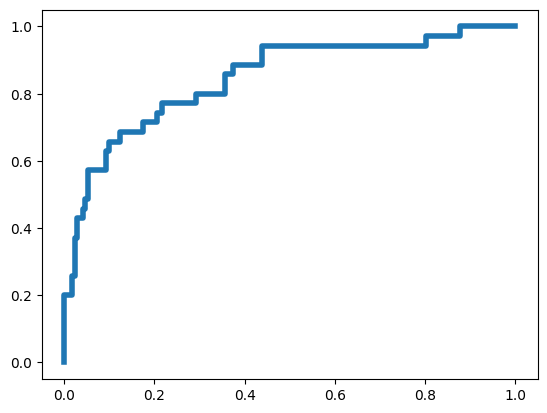

In [9]:
# Evaluate
print('roc_auc:', np.round(roc_auc_score(y_test, y_pred_test_prob), 3))
print('accuracy:', np.round(accuracy_score(y_test, y_pred_test), 3))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob)
plt.plot(fpr, tpr, linewidth=4)
plt.show()

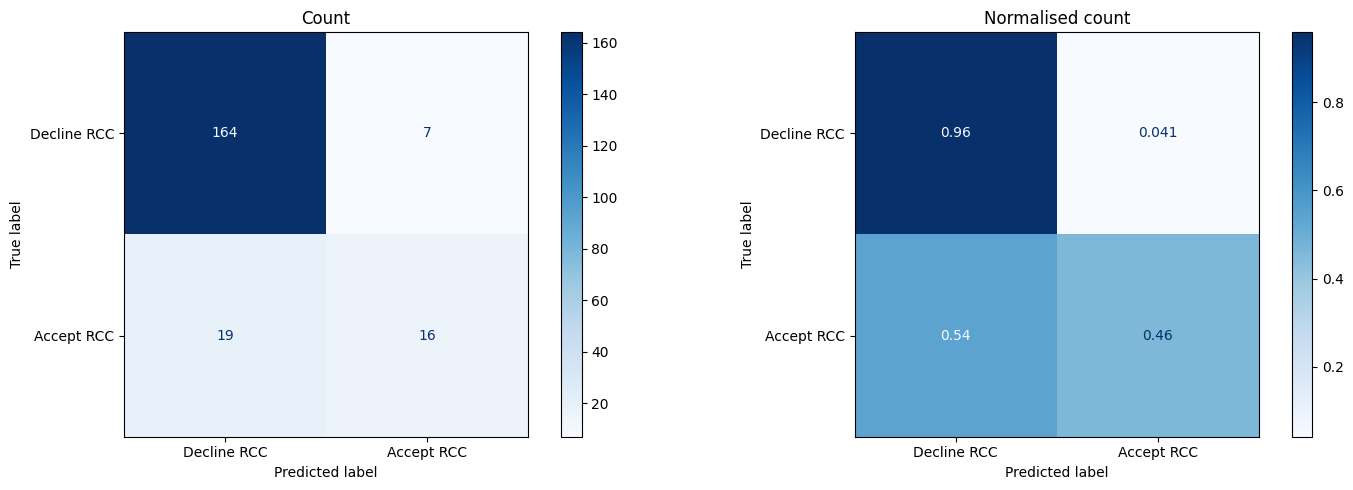

In [10]:
# Confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.from_predictions(y_test, y_pred_test, normalize=None, ax=axs[0], display_labels=['Decline RCC', 'Accept RCC'], cmap='Blues')
axs[0].set_title('Count')
disp.from_predictions(y_test, y_pred_test, normalize='true', ax=axs[1], display_labels=['Decline RCC', 'Accept RCC'], cmap='Blues')
axs[1].set_title('Normalised count')
plt.tight_layout()
plt.show()

In [11]:
# Final model - Trained with the whole dataset
X_final = pd.concat([X_train, X_test], ignore_index=True)
y_final = pd.concat([y_train, y_test], ignore_index=True)

final_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    **clf.best_params_
).fit(X_final, y_final)
# endregion

In [12]:
# region predict RCC
to_predict = pd.read_csv('./data/employee_attrition_lyon.csv')

X_to_predict = preprocess(to_predict, encoder, scaler, imputer, to_drop_cols)
to_predict['RCC_acceptance'] = final_model.predict_proba(X_to_predict)[:, 1]

to_predict.to_csv('./output/lyon_acceptance.csv', index=False)
# endregion
